Mounted at /content/drive
Device: cpu


<ipython-input-1-92bc40bfa90e>:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


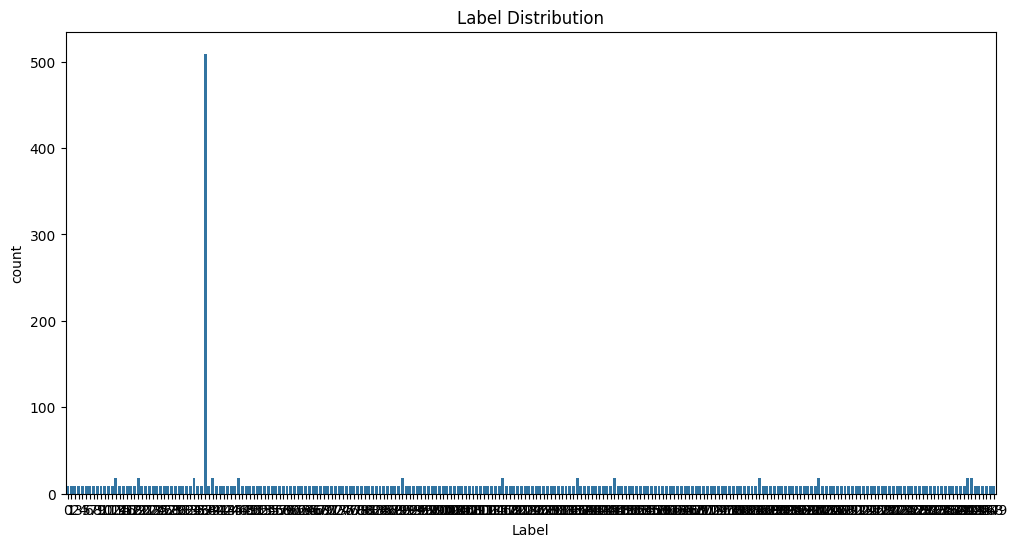

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision Pillow scikit-learn seaborn timm imbalanced-learn

import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timm
from sklearn.utils import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

image_folder = '/content/drive/MyDrive/downsampled_data'
metadata_path = '/content/drive/MyDrive/metadata_BR00116991.csv'

metadata = pd.read_csv(metadata_path)
metadata['FileName_OrigRNA'] = metadata['FileName_OrigRNA'].str.strip().str.lower()

available_files = [f.lower() for f in os.listdir(image_folder)]

metadata['BaseName'] = metadata['FileName_OrigRNA'].str.extract(r'(r\d{2}c\d{2}f\d{2})')[0]
available_files_filtered = [f for f in available_files if any(f.startswith(base) for base in metadata['BaseName'])]

metadata_filtered = metadata[metadata['BaseName'].isin([os.path.splitext(f)[0].split('_median_aggregated')[0] for f in available_files_filtered])]

if len(metadata_filtered) == 0:
    raise ValueError("No matching metadata entries found after filtering. Check the filenames in metadata and directory.")

metadata_filtered = metadata_filtered.reset_index(drop=True)

metadata_filtered['Label'] = metadata_filtered['Metadata_pert_iname'].astype('category').cat.codes

num_classes = metadata_filtered['Label'].nunique()

label_counts = metadata_filtered['Label'].value_counts()

plt.figure(figsize=(12,6))
sns.countplot(x=metadata_filtered['Label'])
plt.title('Label Distribution')
plt.show()

top_n_classes = 50
top_classes = label_counts.head(top_n_classes).index.tolist()

metadata_filtered = metadata_filtered[metadata_filtered['Label'].isin(top_classes)]
metadata_filtered = metadata_filtered.reset_index(drop=True)

metadata_filtered['Label'] = metadata_filtered['Metadata_pert_iname'].astype('category').cat.codes

class_categories = metadata_filtered['Metadata_pert_iname'].astype('category').cat.categories
class_mapping = dict(enumerate(class_categories))
class_names = [class_mapping[i] for i in range(len(class_mapping))]

num_classes = metadata_filtered['Label'].nunique()

image_filenames = [os.path.join(image_folder, f) for f in available_files_filtered if any(base in f for base in metadata_filtered['BaseName'])]

filenames_labels = pd.DataFrame({'filename': image_filenames, 'label': metadata_filtered['Label']})

ros = RandomOverSampler(random_state=42)
filenames_resampled, labels_resampled = ros.fit_resample(filenames_labels[['filename']], filenames_labels['label'])

image_filenames_resampled = filenames_resampled['filename'].tolist()
labels_resampled = labels_resampled.tolist()

from collections import Counter
new_label_counts = Counter(labels_resampled)

train_filenames, val_filenames, y_train, y_val = train_test_split(
    image_filenames_resampled, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled
)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class TiffDataset(Dataset):
    def __init__(self, image_filenames, labels, transform=None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

            image = Image.new('RGB', (128, 128))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

train_dataset = TiffDataset(train_filenames, y_train, transform=train_transform)
val_dataset = TiffDataset(val_filenames, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(labels_resampled), y=labels_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model.train()
running_loss = 0.0
correct_train = 0
total_train = 0
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    with torch.cuda.amp.autocast(enabled=use_amp):
        outputs = model(images)
        loss = criterion(outputs, labels)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()

epoch_loss = running_loss / len(train_dataset)
scheduler.step()

model.eval()
correct = 0
total = 0
val_loss = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_loss = val_loss / len(val_dataset)
val_accuracy = 100 * correct / total

print(f'Train Loss: {epoch_loss:.4f},' f'Val Loss: {val_loss:.4f}')

torch.save(model.state_dict(), 'model.pth')

print(f'Validation Accuracy: {val_accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 50.5MB/s]
<ipython-input-2-3ac0a859c74b>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda

Train Loss: 1.6481,Val Loss: 0.0908
Validation Accuracy: 97.82%


<ipython-input-10-fcdf4b0d6ed4>:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


<Figure size 3000x2700 with 0 Axes>

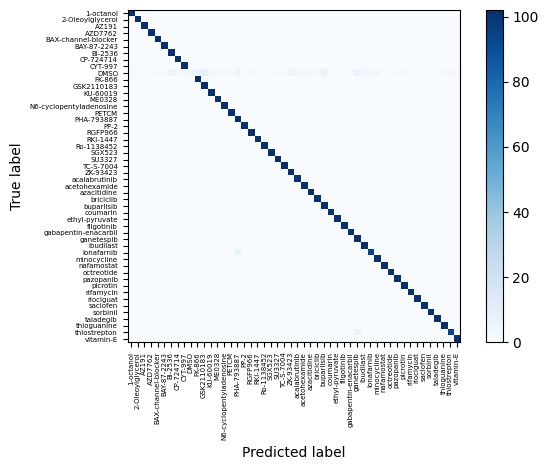

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

plt.figure(figsize=(30, 27))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=False, cmap=plt.cm.Blues, xticks_rotation='vertical')
disp.ax_.tick_params(axis='both', which='major', labelsize=5)
plt.tight_layout()
plt.show()

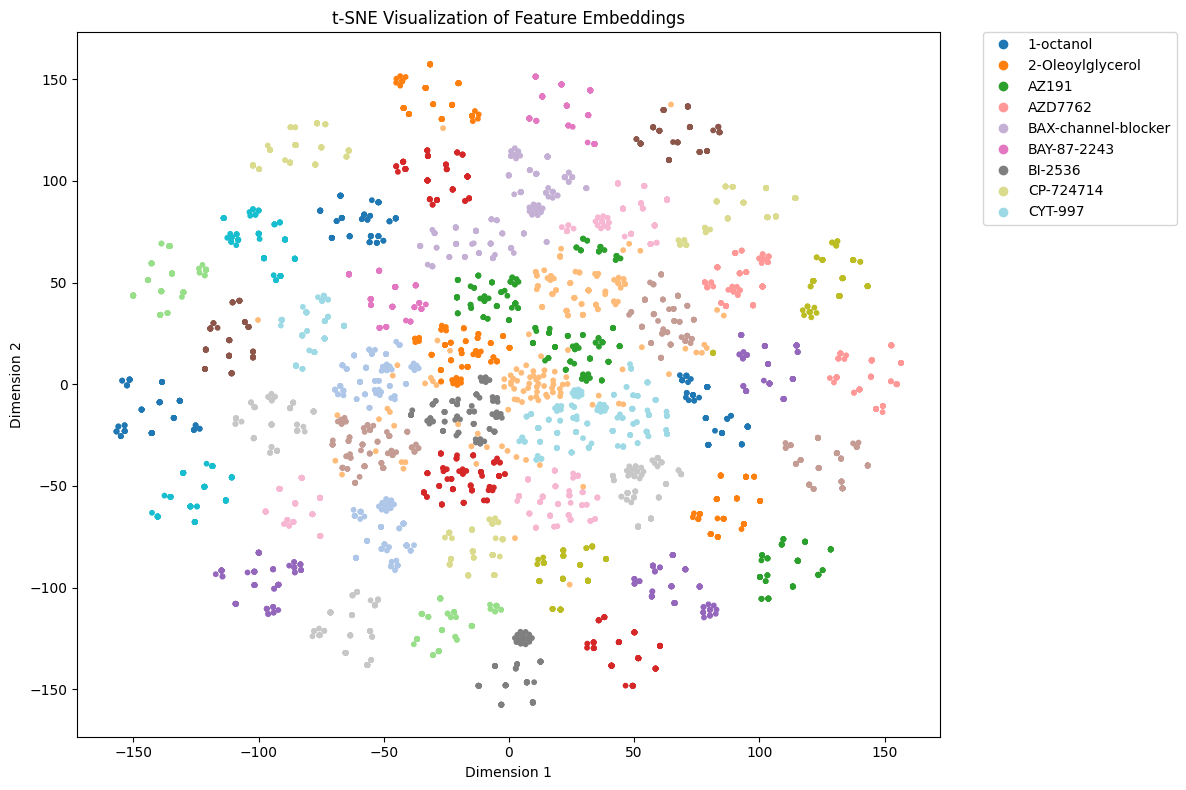

In [ ]:
from sklearn.manifold import TSNE

model.eval()
features = []
labels = []

with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        outputs = model.features(images)
        outputs = torch.nn.functional.adaptive_avg_pool2d(outputs, (1, 1))
        outputs = outputs.view(outputs.size(0), -1)
        features.append(outputs.cpu().numpy())
        labels.extend(label.cpu().numpy())

features = np.concatenate(features)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab20', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('t-SNE Visualization of Feature Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()